# Exploration of confidence or certainty the predictions

In [1]:
run init.ipynb

Done.


#### Init.

In [ ]:
K = 1000

random_states = np.random.randint(0, 1000, K)

for i, random_state in enumerate(random_states):

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = 'multimodal_2023_regular', 
                   positive_class = [1],
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=False, #USE_MISSING_INDICATOR_PREDICTORS,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='multimodal_paper_final', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=5, sample_weight=None, random_state=random_state)
    display(exp.performances_df)
    
    

In [9]:
from sklearn.metrics import  (confusion_matrix, roc_curve, fbeta_score)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, fbeta_score
import prg
from utils import compute_SD
from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve

def compute_results(y_true, y_pred, threshold, name='?', title=""):


    # Compute imbalance_ratio of our sample
    pi = y_true.mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
    
    # Compute first AUROC
    auroc = roc_auc_score(y_true, y_pred)

    # Compute the AUC-PR
    auc_pr = average_precision_score(y_true, y_pred)

    # Compute the AUC-PR Corrected
    auc_pr_corrected = average_precision(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    # Compute the AUC-PR Gain
    auc_pr_g = prg.calc_auprg(prg.create_prg_curve(y_true, y_pred))

    # Compute the AUC-PR Gain corrected
    auc_pr_g_corrected = calc_auprg(create_prg_curve(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO))
    
    # Compute f1 and f2 scores
    f1 = fbeta_score(y_true, y_pred > threshold, beta=1) 
    f2 = fbeta_score(y_true, y_pred >= threshold, beta=2) 

    # Compute the F1 score
    #f1, _ = bestf1score(y_true, y_pred, pi0=None)

    # Compute the corrected F1 score
    #f1_corrected, _ = bestf1score(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= threshold).ravel()

    # Compute corrected precision (ppv)
    ppv_corr = tp/(tp+correction_factor*fp)
    
    npv_corr = (correction_factor*tn)/(correction_factor*tn+fn)

    acc = (tp + tn) / (tp + tn + fp +  fn)
    mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    tpr =  tp / (tp+fn)
    tnr = tn / (tn+fp)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    fnr = fn / (tp+fn)
    
    # Compute corrected F1 and F2
    f1_c = 2*(ppv_corr*tpr)/(ppv_corr+tpr)
    
    beta = 2
    f2_c = (1+beta**2)*(ppv_corr*tpr)/(beta**2 * ppv_corr + tpr)

    performances_dict = {'name':name+'\n(N='+str(len(y_true))+')', 
                         'AUROC':round(auroc, 3),
                        'AUC-PR': round(auc_pr, 3),
                        'AUC-PR-Gain': round(auc_pr_g, 3),
                        'AUC-PR-Corrected': round(auc_pr_corrected, 3),
                        'AUC-PR-Gain-Corrected' :round(auc_pr_g_corrected, 3),
                        'F1 score (2 PPVxTPR/(PPV+TPR))': round(f1, 3),
                        'F1 score Corrected': round(f1_c, 3),
                        'F2': round(f2, 3),
                        'F2 Corrected': round(f2_c, 3),
                        'Accuracy' : round(acc, 3),
                        'Matthews correlation coefficient (MCC)': round(mcc, 3),
                        'Sensitivity, recall, hit rate, or true positive rate (TPR)': round(tpr, 3),
                        'Specificity, selectivity or true negative rate (TNR)': round(tnr, 3),
                        'Precision or positive predictive value (PPV)': round(ppv, 3),
                        'Corrected Precision or positive predictive value (PPV)': round(ppv_corr, 3),
                        'Corrected NPV': round(npv_corr, 3),
                        'Negative predictive value (NPV)': round(npv, 3),
                        'Miss rate or false negative rate (FNR)': round(fnr, 3),
                        'False discovery rate (FDR=1-PPV)': round(1-ppv, 3),
                        'False omission rate (FOR=1-NPV)': round(1-npv, 3),
                        'TP': tp,
                        'TN': tn,
                        'FP': fp,
                        'FN': fn
                        }
    
    performances_df = pd.DataFrame(performances_dict, index=[name+'\n(N='+str(len(y_true))+')'])

    performances_df['TN'] = tn
    performances_df['TP'] = tp
    performances_df['FP'] = fp
    performances_df['FN'] = fn

    performances_df['TN_normalized'] = 100*tn/len(y_true)
    performances_df['TP_normalized'] = 100*tp/len(y_true)
    performances_df['FP_normalized'] =  100*fp/len(y_true)
    performances_df['FN_normalized'] =  100*fn/len(y_true)    
    performances_df['N'] = len(y_true) 
    performances_df['y_true'] = [y_true]
    performances_df['y_pred'] = [y_pred]
    performances_df['Hanley_CI'] = performances_df['AUROC'] .apply(lambda x: compute_SD(x, np.sum(y_true==0), np.sum(y_true==1)))

    
    
    
    if False:
        display(performances_df)

        fig_mosaic = """
                        AB
                    """

        fig, axes = plt.subplot_mosaic(mosaic=fig_mosaic, figsize=(10,5))

        fig.suptitle(title, y=1.1, weight='bold', fontsize=12)

        cm = confusion_matrix(y_true, y_pred >= threshold)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=axes['B']);disp.im_.colorbar.remove()    

        # Plot the roc curves

        fpr, tpr, _ = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
        axes['A'].plot(fpr, tpr, '-', color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc,)
        axes['A'].plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
        axes['A'].set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); axes['A'].grid()
        axes['A'].set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')

        plt.tight_layout()
        plt.show()
    return performances_df

In [298]:
#df = create_autism_df(folder_names = ['24_Janvier_Final_Importance_Computation_with_pwb_ddld_depth_5_test_1'])#'13_november_bis'])#'November 2022'])
df = create_autism_df(folder_names = ['25_Janvier_Final_Importance_Computation_with_pwb'])#'13_november_bis'])#'November 2022'])

100%|██████████| 101/101 [00:36<00:00,  2.77it/s]


**Computation of the average Shap values (no normalisation yet)**

In [213]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/25_Janvier_Final_Importance_Computation_with_pwb/SenseToKnow/'

json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))
i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])
    # except:
    #     print("Error parsing json")


shap_interactions = np.concatenate(shap_interactions_all_cv)
shap_interactions.shape

(100, 377, 23, 23)

**Computation of the feature impotance by summing over the interactions effect**

In [214]:
shap_values = shap_interactions.sum(axis=2)
shap_values.shape

(100, 377, 23)

**Normalization of the Shap values for each individuals so that the Shap values are comparable, given that they come from differet models being trained.**

In [215]:
shap_values_n = shap_values / np.abs(shap_values).sum(axis=2)[:, :, np.newaxis]

np.abs(shap_values_n[0, 0]).sum()

1.0

**For a random individual this shows the fluctuations of their Shap values over different training step of the Cross-Validation**

The fluctuations we observe are due to the models differences when training it using different set of training data when the random sample is among the test set. Ideally if the model does not overfit the data and is robust, we should not see significant fluctuations

Subject:192


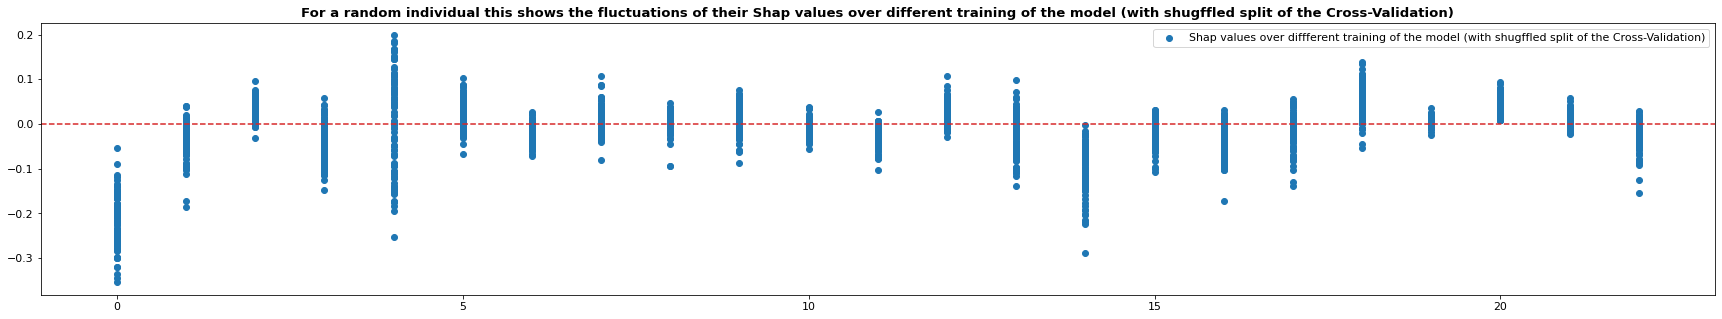

In [216]:
subject_of_interest = np.random.randint(shap_interactions.shape[1])
print("Subject:{}".format(subject_of_interest))

fi(30, 5)
n_model = shap_interactions.shape[0]
plt.title("For a random individual this shows the fluctuations of their Shap values over different training of the model (with shugffled split of the Cross-Validation)", weight='bold')
for i  in range(shap_interactions.shape[2]):
    plt.scatter([i]*n_model, shap_values_n[:, subject_of_interest, i], color='tab:blue', label="Shap values over diffferent training of the model (with shugffled split of the Cross-Validation)" if i==0 else None)
    
plt.axhline(0, linestyle='--', color='tab:red')
_ = plt.legend()


**Now we average the shap values over the K (=50)  training that were performed.**

In [217]:
shap_values_n.shape

(100, 377, 23)

**Averaging the Shap values over the different training**

In [ ]:
shap_values_averaged = shap_values_n.mean(axis=0)

**Note that the Shap values of the samples are no longer normalized because of the averaging over different training, see here the average sum of absolute shap values:**

In [220]:
np.abs(shap_values_averaged).sum(axis=1).mean()

0.9183734713599317

**We therefore renormalize them**

In [221]:
shap_values_averaged_n = shap_values_averaged / np.abs(shap_values_averaged).sum(axis=1)[:, np.newaxis]
np.abs(shap_values_averaged_n).sum(axis=1).mean()

1.0

**We now check that the final Shap values for 5 random samples are consistent with what we can observe during a random taining for a sample**

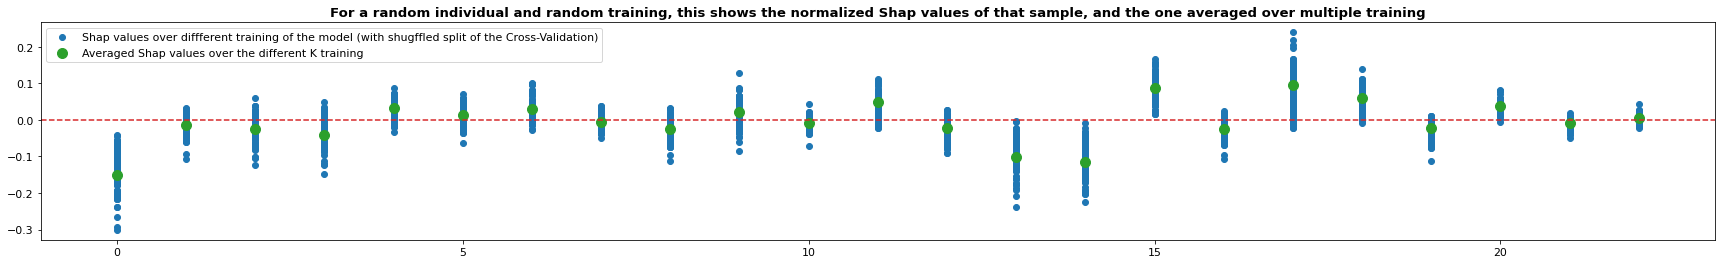

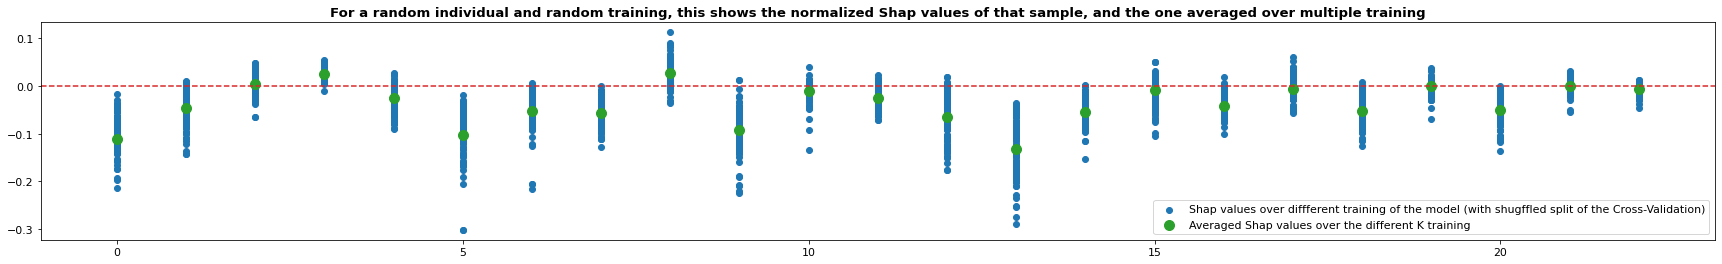

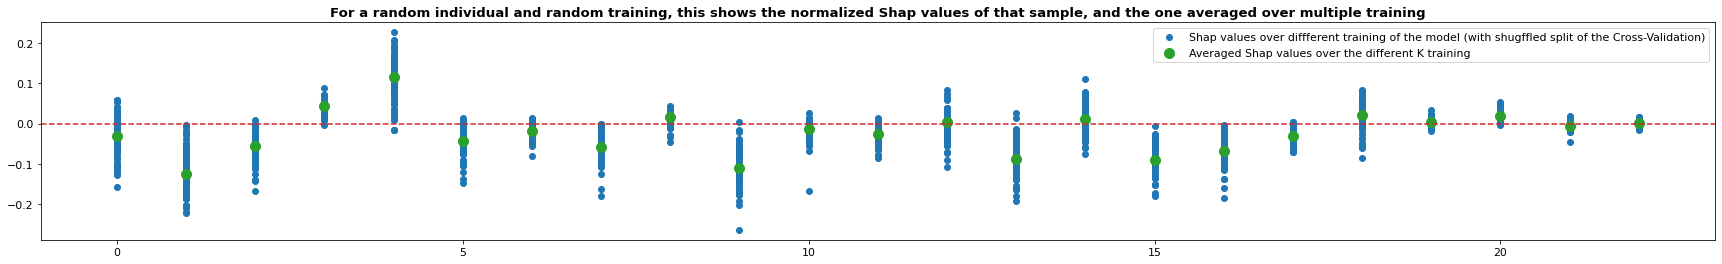

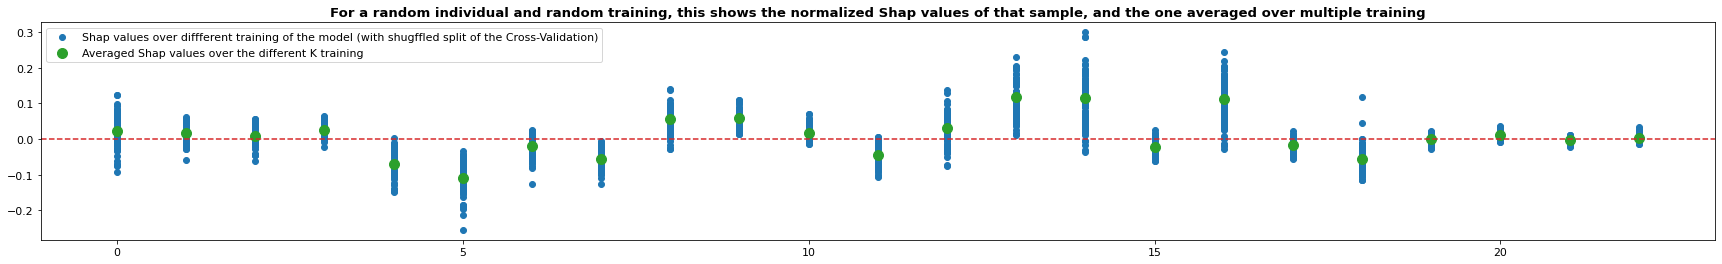

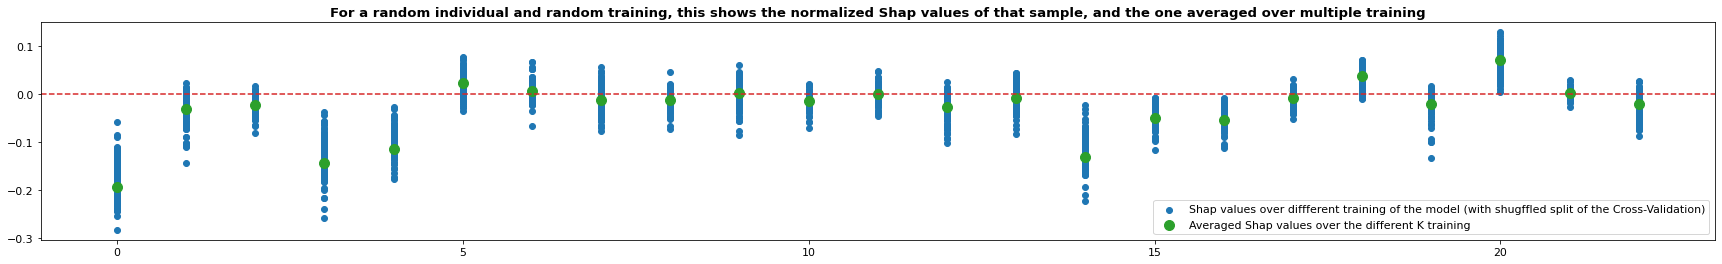

In [222]:
random_samples =  np.random.randint(0, shap_values_n.shape[1], 5)


for random_sample in random_samples:

    n_training = shap_values_n.shape[0]
    fi(30, 4)
    plt.title("For a random individual and random training, this shows the normalized Shap values of that sample, and the one averaged over multiple training", weight='bold')
    for i  in range(shap_values_averaged_n.shape[1]):
        plt.scatter([i]*n_training, shap_values_n[:, random_sample, i], color='tab:blue', label="Shap values over diffferent training of the model (with shugffled split of the Cross-Validation)" if i==0 else None)
        plt.scatter([i], shap_values_averaged_n[random_sample, i], color='tab:green', s=100, label="Averaged Shap values over the different K training" if i==0 else None)
    plt.axhline(0, linestyle='--', color='tab:red')
    plt.legend()
    plt.show()

**At this point, `shap_values_averaged_n` contains the Shap Values of the final sample.** 

- We can compute the compliance score
- We could plot the final Shap values importance but we need to see if sampling will be improving

In [223]:
np.save(os.path.join(DATA_DIR, 'multimodal_paper', 'Average_normalized_Shap_values_regular_sample_before_weighting.npy'), shap_values_averaged_n)

# Computation of the shapley values acccounting for features missingness.

For each of the stored Shap values (i.e. the attribution of features importance on each sample), some might be associated to the contribution of the feature being missing, if for that sample the feature were actually missing.
In order to put things in order and disentangled to importance of the features values and their missingness, we here set to 0 the shapley value asociated to missing feature (HYP: the underlying hypothesis of doing that is that if a value is unknown, its contribution should be 0, and rather what should have this contrinution is the missingness of that variable).

*Notes*
- Given that the shap values was collected on each sample using cross-validation, i.e training a different model every time, we cannot compare or average the shap values directly. We first need to normalize each shap values $(\phi_k^i)_{k \in [1, K]}$ for $i \in [1, N]$. Since the sign is informative we still conserve it. 
- We verify that the features themselves have higher importance than their missingness.
- To compute the global importance of each of the features (when there are known, not when we miss them), we proceed as follows:
    1) First we only take into account the first half of the `general_shap_values_normalized` (features attribution when the values are know)

In [224]:
print("{} missing values".format((np.isnan(exp.dataset._X_train)).astype(int).sum()))

851 missing values


In [225]:
shap_values_averaged_n.shape

(377, 23)

In [13]:
ROOT_DIR

'/home01/sam/notes_on_stats/doc/'

In [ ]:
import shap
fig = shap.summary_plot(shap_values_averaged_n, exp.dataset._X_train, feature_names = [feature_name_mapping[f] for f in exp.features_name], plot_size=(35, 15), show=False)# plot_type='bar')

ax= plt.gca()
list_labels = [l._text for l in  ax.get_yticklabels()]
ax.set_yticks(ax.get_yticks(), list_labels, weight='bold', fontsize=20, **csfont)
ax.set_xticks(ax.get_xticks(), np.round(ax.get_xticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)
ax.set_xlabel("SHAP values (contribution to the model's prediction)", weight='bold', fontsize=20, **csfont)
      
ax.set_facecolor('white')
plt.gcf().patch.set_facecolor('white')
plt.colorbar(ticks=range(6), label='')

plt.savefig(os.path.join(ROOT_DIR, 'figures', 'features_importance.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [228]:
[(feat, val) for feat, val in zip(exp.features_name, np.round(np.abs(shap_values_averaged_n).mean(axis=0)*100, 2))]

[('mean_gaze_percent_right', 11.13),
 ('gaze_silhouette_score', 3.38),
 ('FP_gaze_speech_correlation', 2.75),
 ('proportion_of_name_call_responses', 5.95),
 ('average_response_to_name_delay', 6.98),
 ('S_postural_sway', 6.45),
 ('NS_postural_sway', 2.53),
 ('S_postural_sway_derivative', 4.0),
 ('NS_postural_sway_derivative', 2.81),
 ('S_postural_sway_complexity', 6.9),
 ('NS_postural_sway_complexity', 1.1),
 ('S_blink_rate', 2.08),
 ('NS_blink_rate', 2.65),
 ('S_facing_forward', 11.08),
 ('NS_facing_forward', 6.14),
 ('S_eyebrows_complexity', 4.37),
 ('NS_eyebrows_complexity', 4.85),
 ('S_mouth_complexity', 2.35),
 ('NS_mouth_complexity', 5.33),
 ('pop_rate', 0.98),
 ('std_error', 4.8),
 ('average_length', 0.53),
 ('average_force_applied', 0.89)]

**We now disembiguate the missing and present shap valeus for each samples using masking**

In [229]:
mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values_averaged_n, mask_shap_present)
shap_missing = np.multiply(shap_values_averaged_n, (mask_shap_present==0).astype(int))

**Concatenate shap value separating real variables and when there are missing. Note that we did not lost the normalization**

In [230]:
general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)

np.abs(general_shap_values).sum(axis=1).mean()

1.0

**We now normalize the absolute Shap values over samples, and average them, to have the Final features importances per variables + per missingness.**

In [231]:
general_shap_values_normalized = np.abs(general_shap_values)/ np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]


In [232]:
features_importances_extended = general_shap_values_normalized.sum(axis=0)/general_shap_values_normalized.sum()
np.abs(features_importances_extended).sum(axis=0)

1.0

**We now visualize the features contribution of the present variables and the contributions of the missing ones**

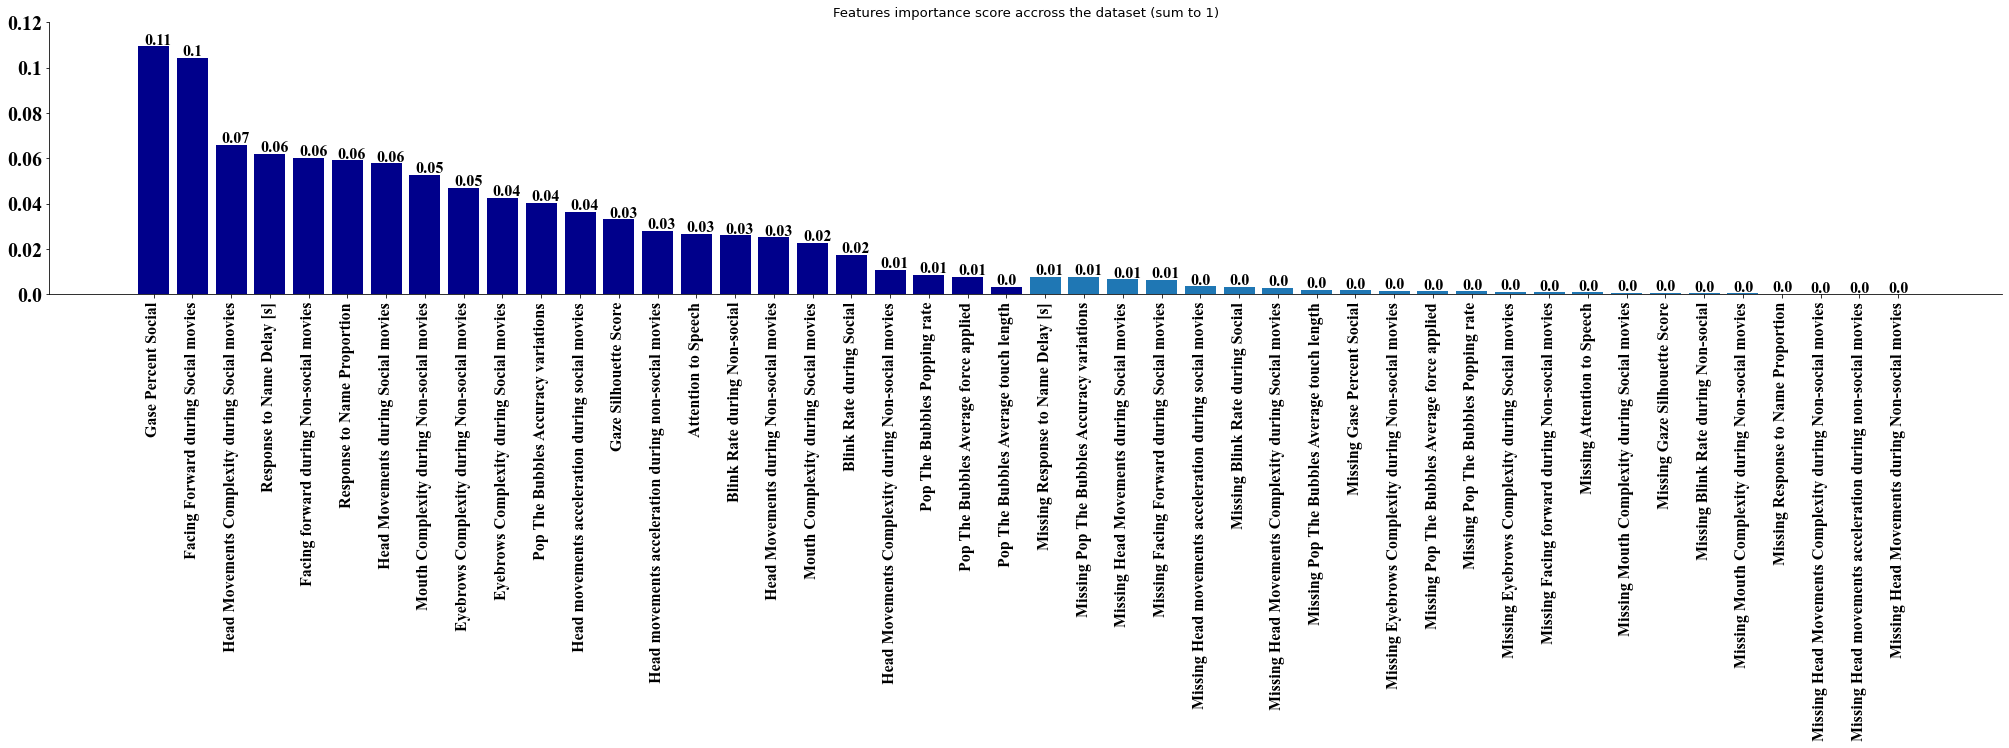

In [233]:
labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]       
n_features = len(exp.features_name)

#We first plot the present ones
idx_sorting_present = list(reversed(np.argsort(features_importances_extended[:n_features])))
offset=0.001
fi(35, 5)
plt.title("Features importance score accross the dataset (sum to 1)")
for i, feat in enumerate(np.array(exp.features_name)[idx_sorting_present]):
    plt.bar(i, features_importances_extended[idx_sorting_present][i], color='darkblue')
    plt.annotate(str(np.round(features_importances_extended[idx_sorting_present][i], 2)), (i-.25, features_importances_extended[idx_sorting_present][i] + offset), weight='bold', fontsize=16, **csfont)
    
    
idx_sorting_missing = list(reversed(np.argsort(features_importances_extended[n_features:])))
idx_sorting_missing = list(np.array(idx_sorting_missing) + n_features)
#And then the missing ones
for i, feat in enumerate(np.array(labels)[idx_sorting_missing]):
    j = i + n_features
    plt.bar(j, features_importances_extended[idx_sorting_missing][i], color='tab:blue')
    plt.annotate(str(np.round(features_importances_extended[idx_sorting_missing][i], 2)), (j-.25, features_importances_extended[idx_sorting_missing][i] + offset), weight='bold', fontsize=16, **csfont)
    
idx_sorting = idx_sorting_present + idx_sorting_missing
plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels= [feature_name_mapping[f] if f[0] != 'Z' else "Missing " + feature_name_mapping[f[2:]] for f in np.array(labels)[idx_sorting]], rotation =90, weight='bold', fontsize=16, **csfont)
#plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=[feature_name_mapping[f] for f in np.array(labels)[idx_sorting]], rotation =90)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=20, **csfont)
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'features_importance_present_missing.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')


#percent_missing_importance_mean = (1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).mean()*100
#percent_missing_importance_std =(1 - features_importances_extended[:len(exp.features_name)].sum(axis=1)).std()*100

#print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

**For the computation of the compliance score, we are now interested only in the features that are present, and without the indicator variables.**

There are not normalized so we first need to renormalized them (some importance were allocated to the missing variables and Z)

In [239]:
shap_present_real_variables = shap_present[:, :23]
np.abs(shap_present_real_variables).sum(axis=1).mean()

0.9482972436564855

In [240]:
shap_present_normalized = np.abs(shap_present_real_variables) / np.abs(shap_present_real_variables).sum(axis=1)[:, np.newaxis] 
np.abs(shap_present_normalized).sum(axis=1).mean()

1.0

**We now average over the participants to get th importance of the present variables to the model**

In [241]:
features_importance_present_n = np.abs(shap_present_normalized).sum(axis=0)/ np.abs(shap_present_normalized).sum()
features_importance_present_n.shape

(23,)

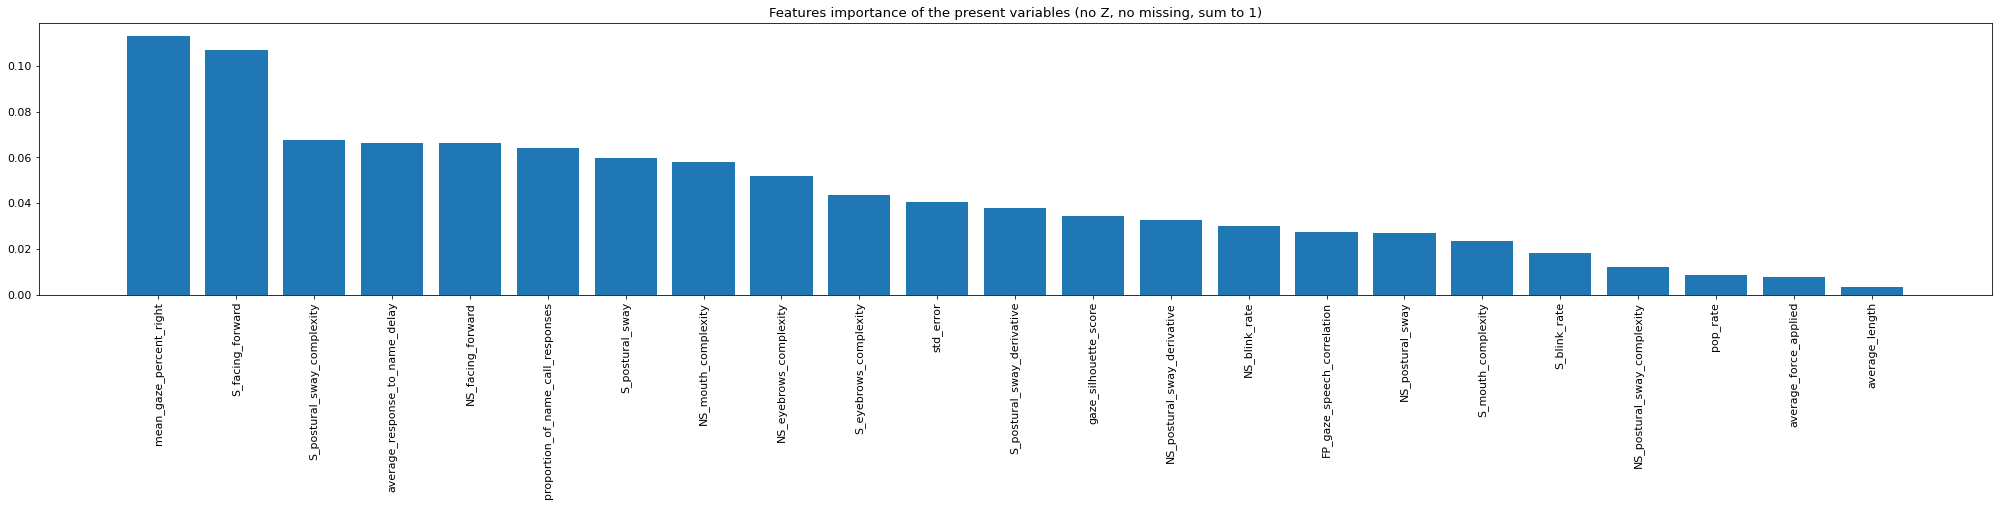

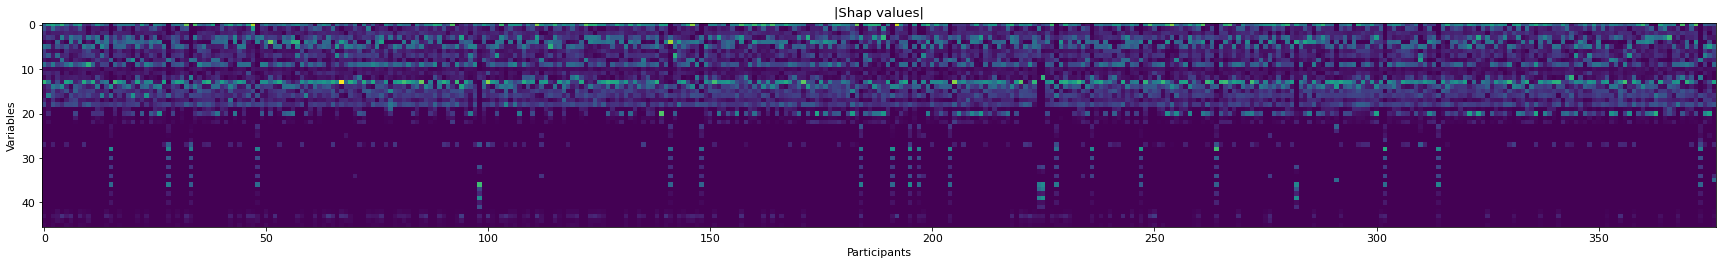

In [242]:
idx_ordered = list(reversed(np.argsort(features_importance_present_n)))

fi(35, 5)
plt.title("Features importance of the present variables (no Z, no missing, sum to 1)")
for i, (idx, feat) in enumerate(zip(idx_ordered, np.array(exp.features_name[:23])[idx_ordered])):
    plt.bar(i, features_importance_present_n[idx], color='tab:blue')
plt.xticks(ticks = np.arange(features_importance_present_n.shape[0]), labels=np.array(exp.features_name[:23])[idx_ordered], rotation =90)
None


fi(30, 35)
plt.title("|Shap values|")
plt.imshow(general_shap_values_normalized.transpose())
plt.xlabel("Participants")
plt.ylabel("Variables")   
None

**We can store the importance of each of the features to the model**

This is super useful when we extend the cohort or use the DDLD, we can therefore directly use this, the confidence score of each snew samples (computed from their available data), and so compute the compiance score of each participant. 

In [243]:
features_importance_present_n

array([0.11315872, 0.03425091, 0.02745568, 0.06393428, 0.06642852,
       0.0596584 , 0.02699794, 0.03768584, 0.03267748, 0.06757193,
       0.01196459, 0.0180624 , 0.02994581, 0.10705289, 0.06642611,
       0.04341091, 0.05191672, 0.02326756, 0.05782543, 0.0086236 ,
       0.04053777, 0.00334531, 0.00780119])

In [244]:
np.save(os.path.join(DATA_DIR, 'multimodal_paper', 'features_importance_present_n.npy'), features_importance_present_n)

# Building W the matrix of confidence in the different measure


In this section we aim at weighting the confidence we have in each of the input. The weight are between 0 and 1. This is an initial potentially naive way ay of weigthing the features confidences.
- For features that are an aggregation of the same feature over multiple videos, we use linear weighting (1 is all measures are available 0 otherwise, with linear mapping between these extremes).
- For the name call variables, we use the number of valid name call experiemnts. This can be 0, 1, 2, or 3. If 0 valid name call experiment, we set the weigths to 0. If there are at least one valid experiement, we still may or not ghave the information of the delay. In this case there are two scenraio that have been discussed. Either the participant answered and so the weighting is the same as the proportion of valid name call. If the participant did not answer, there is no "delay experiment", and so we set it to 0 (and not to the proportion...).
- For the touch variables, a measure of confidence we may have on the different variables could be proportional to the number of touches, with a maxmum confidence when the number of touches is higher than e.g. 15. 

For missing features, we let their weight to be 0, as we don't have the information of their value, but set to 1 the weight attributed to the indicator variable of its missingness (as xgboost handles missing data, it still uses the information of that feature being missing, so this information is accouted for).


There are two ways we can use these weights. 
1) During training and inference, we weight the input matrix by these weights, which influence the weighting of the gradient and hessian statiastics of the different optimization steps. 
2) More complex, using Bayesian ideas. We can see the input features as gaussians, with for instance a sigma parameter close to 0 if we have some certainty about the measure, and larger (value depends on the feature range etc), for input we are not to sure about.



In [245]:
# Computation of the confidence scores
exp.dataset.df['S_blink_rate_conf'] = (~exp.dataset.df[['MML_blink_rate', 'FP_blink_rate', 'PWB_blink_rate']].isna()).sum(axis=1)/3
exp.dataset.df['NS_blink_rate_conf'] = (~exp.dataset.df[['DIGC_blink_rate', 'DIGRRL_blink_rate', 'FB_blink_rate', 'MP_blink_rate']].isna()).sum(axis=1)/4


exp.dataset.df['S_postural_sway_conf'] = (~exp.dataset.df[['ST_postural_sway', 'BB_postural_sway', 'MML_postural_sway', 'FP_postural_sway', 'PWB_postural_sway']].isna()).sum(axis=1)/5
exp.dataset.df['NS_postural_sway_conf'] = (~exp.dataset.df[['DIGC_postural_sway', 'DIGRRL_postural_sway', 'FB_postural_sway', 'MP_postural_sway']].isna()).sum(axis=1)/4

exp.dataset.df['S_postural_sway_derivative_conf'] = (~exp.dataset.df[['ST_postural_sway_derivative', 'BB_postural_sway_derivative', 'MML_postural_sway_derivative', 'FP_postural_sway_derivative', 'PWB_postural_sway_derivative']].isna()).sum(axis=1)/5
exp.dataset.df['NS_postural_sway_derivative_conf'] = (~exp.dataset.df[['DIGC_postural_sway_derivative', 'DIGRRL_postural_sway_derivative', 'FB_postural_sway_derivative', 'MP_postural_sway_derivative']].isna()).sum(axis=1)/4

exp.dataset.df['gaze_silhouette_score_conf'] = (~exp.dataset.df[['BB_gaze_silhouette_score','S_gaze_silhouette_score']].isna()).sum(axis=1)/2
exp.dataset.df['mean_gaze_percent_right_conf'] = (~exp.dataset.df[['S_gaze_percent_right','BB_gaze_percent_right']].isna()).sum(axis=1)/2
exp.dataset.df['FP_gaze_speech_correlation_conf'] = (~exp.dataset.df[['FP_gaze_speech_correlation']].isna()).sum(axis=1)

exp.dataset.df['S_facing_forward_conf'] = (~exp.dataset.df[['ST_facing_forward', 'BB_facing_forward', 'MML_facing_forward', 'FP_facing_forward', 'PWB_facing_forward']].isna()).sum(axis=1)/5
exp.dataset.df['NS_facing_forward_conf'] = (~exp.dataset.df[['DIGC_facing_forward', 'DIGRRL_facing_forward', 'FB_facing_forward', 'MP_facing_forward']].isna()).sum(axis=1)/4

exp.dataset.df['S_eyebrows_complexity_conf'] = (~exp.dataset.df[['ST_eyebrows_complexity', 'BB_eyebrows_complexity', 'MML_eyebrows_complexity', 'FP_eyebrows_complexity', 'PWB_eyebrows_complexity']].isna()).sum(axis=1)/5
exp.dataset.df['NS_eyebrows_complexity_conf'] = (~exp.dataset.df[['DIGC_eyebrows_complexity', 'DIGRRL_eyebrows_complexity', 'FB_eyebrows_complexity', 'MP_eyebrows_complexity']].isna()).sum(axis=1)/4

exp.dataset.df['S_mouth_complexity_conf'] = (~exp.dataset.df[['ST_mouth_complexity', 'BB_mouth_complexity', 'MML_mouth_complexity', 'FP_mouth_complexity', 'PWB_mouth_complexity']].isna()).sum(axis=1)/5
exp.dataset.df['NS_mouth_complexity_conf'] = (~exp.dataset.df[['DIGC_mouth_complexity', 'DIGRRL_mouth_complexity', 'FB_mouth_complexity', 'MP_mouth_complexity']].isna()).sum(axis=1)/4

exp.dataset.df['S_postural_sway_complexity_conf'] = (~exp.dataset.df[['ST_head_movement_complexity', 'BB_head_movement_complexity', 'MML_head_movement_complexity', 'FP_head_movement_complexity', 'PWB_head_movement_complexity']].isna()).sum(axis=1)/5
exp.dataset.df['NS_postural_sway_complexity_conf'] = (~exp.dataset.df[['DIGC_head_movement_complexity', 'DIGRRL_head_movement_complexity', 'FB_head_movement_complexity', 'MP_head_movement_complexity']].isna()).sum(axis=1)/4


exp.dataset.df['RTN_conf'] = exp.dataset.df['valid_name_calls'].apply(lambda x: np.sum(x))/3
exp.dataset.df['touch_conf'] = exp.dataset.df['number_of_touches'].apply(lambda x: 0 if np.isnan(x) else x/15  if x <=15 else 1. if x>= 16 else 0)




for conf_col in ['S_postural_sway_conf', 'NS_postural_sway_conf', 'S_postural_sway_derivative_conf', 'NS_postural_sway_derivative_conf',
                 'gaze_silhouette_score_conf', 'mean_gaze_percent_right_conf', 'proportion_of_name_call_responses_conf', 'average_response_to_name_delay_conf', 'touch_conf']:
    
    pass#exp.dataset.df.loc[exp.dataset.df[conf_col]==0, conf_col] = 1
    

conf_values = np.zeros((exp.dataset.num_samples, len(DEFAULT_PREDICTORS)))

for i, feat in enumerate(DEFAULT_PREDICTORS):
    
    if feat in TOUCH_VARIABLES:
        
        # These features don't depend on the number of touches, it is a value that we measures and so its confidence should be 1. 
        # We weight only the features that depend on the number of features.
        if feat in ['number_of_touches', 'number_of_target']:
            
            conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int)
        
        else:
            
            conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int) * exp.dataset.df['touch_conf']
        
    elif feat == 'proportion_of_name_call_responses':
        
        conf_values[:, i] = exp.dataset.df['RTN_conf']
        
    elif feat == 'average_response_to_name_delay':
        
        # 0 if the delay is missing, the proportion of valid  name calls otherwise
        
        conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int) * exp.dataset.df['RTN_conf']
            
    else:
        conf_values[:, i] = exp.dataset.df['{}_conf'.format(feat)]
        
    

In [246]:
exp.dataset._X_train.shape

(377, 23)

In [247]:
    
# ----------------- Shanity check: show the values that are missing but don't have a confidence set to 0 (should not be the case) -----------------------
# Pour toutes les nan des features
for coord in np.argwhere((mask_shap_present.astype(int)==0).astype(int) == 1):
    
    # Est-ce que la matrice de W est bien 0 ? 
    if conf_values[coord[0]][coord[1]] != 0 :
        print(coord, conf_values[coord[0]][coord[1]], exp.dataset._X_train[coord[0]][coord[1]])
        
        
# ----------------- Shanity check: show the values that have a confidence of 0 but are not msising (should only be the case for the RTN delay if no valid NC) -----------------------
# Pour toutes les nan des features
for coord in np.argwhere(conf_values==0):
    
    # Est-ce que la matrice de W est bien 0 ? 
    if not np.isnan(exp.dataset._X_train[coord[0]][coord[1]]):
        if exp.features_name[coord[1]] != 'average_response_to_name_delay':
            print(coord, exp.dataset._X_train[coord[0]][coord[1]], exp.features_name[coord[1]])
            
            

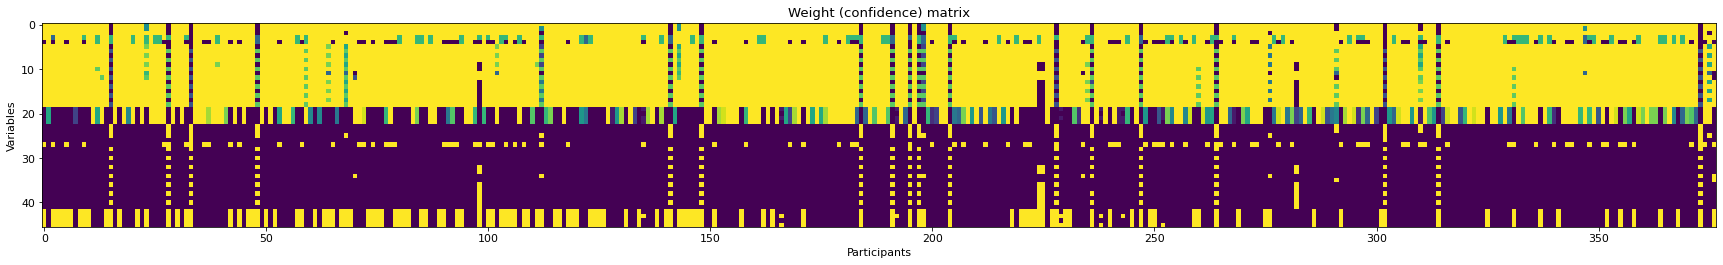

In [248]:
            
# --------------- Add the weights asssociated with the missingness ---------------------- #
conf_values = np.concatenate([conf_values, np.isnan(exp.dataset._X_train).astype(int)], axis=1)

fi(30, 35)
plt.title("Weight (confidence) matrix")
plt.imshow(conf_values.transpose())
plt.xlabel("Participants")
plt.ylabel("Variables")   
None

In [85]:
# Experimental ...

#exp.dataset.df['Measures Confidence Uniform'] = exp.dataset.df[['S_postural_sway_conf', 'NS_postural_sway_conf', 'S_postural_sway_derivative_conf',
#                                                        'NS_postural_sway_derivative_conf', 'gaze_silhouette_score_conf', 'mean_gaze_percent_right_conf', 
 #                                                       'RTN_conf', 'touch_conf']].sum(axis=1)/8


#exp.dataset.df['Measures Confidence Weighted'] =  conf_values[:, :12].sum(axis=1)/12

# Computation of a quality score for each of the participants


Now that we computed the relative contribution of each features (and their missingness) for each participants, $G(X)$, and a confidence score associated in each of the variables, $W(X)$, we can compute a general confidence score on the prediction based on the initial information we had on each sample. 

The way to think about it seems to be: okay we had a certain distribution of confidence across the variables, they all have different importance to make the final prediction, what is the final confidence we have for a sample ? 


$$ Quality (X^i) = \sum_{k=0}^K G(X^i_k) W(X^i_k) $$




This quality has value between 0 and 1, with 1 when all features are available.general_shap_values_normalized

In [249]:
features_importance_present_n

array([0.11315872, 0.03425091, 0.02745568, 0.06393428, 0.06642852,
       0.0596584 , 0.02699794, 0.03768584, 0.03267748, 0.06757193,
       0.01196459, 0.0180624 , 0.02994581, 0.10705289, 0.06642611,
       0.04341091, 0.05191672, 0.02326756, 0.05782543, 0.0086236 ,
       0.04053777, 0.00334531, 0.00780119])

In [250]:
# Computation of the quality score ! 
weighted_confidence_score = np.multiply(conf_values[:,:len(features_importance_present_n)], features_importance_present_n).sum(axis=1)
np.save(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'), weighted_confidence_score)

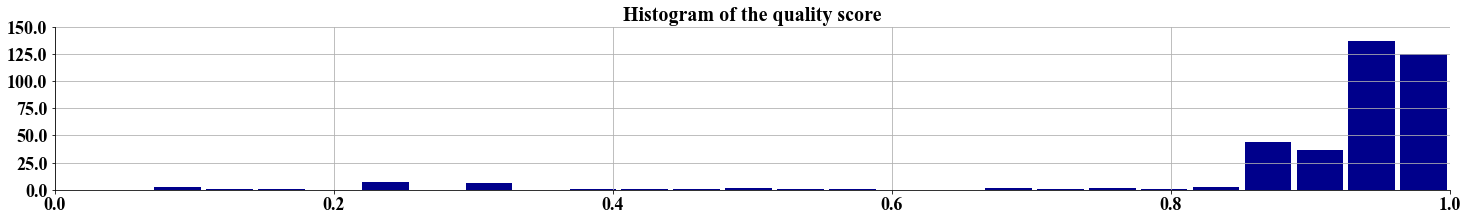

In [251]:
#weighted_confidence_score = np.multiply(conf_values, general_shap_values_normalized).sum(axis=1)
fi(25, 3)
plt.title("Histogram of the quality score", weight='bold', fontsize=20, **csfont)
plt.hist(weighted_confidence_score.flatten(), color='darkblue', bins=25, rwidth=.9)

#plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=[feature_name_mapping[f] for f in np.array(labels)[idx_sorting]], rotation =90)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.xlim([0, 1])
plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.gca().set_xticks(plt.gca().get_xticks(), np.round(plt.gca().get_xticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.grid()
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'compliance_score_hist.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')



None

# Computation of the shapley values acccounting for features missingness.

For each of the stored Shap values (i.e. the attribution of features importance on each sample), some might be associated to the contribution of the feature being missing, if for that sample the feature were actually missing.
In order to put things in order and disentangled to importance of the features values and their missingness, we here set to 0 the shapley value asociated to missing feature (HYP: the underlying hypothesis of doing that is that if a value is unknown, its contribution should be 0, and rather what should have this contrinution is the missingness of that variable).

*Notes*
- Given that the shap values was collected on each sample using cross-validation, i.e training a different model every time, we cannot compare or average the shap values directly. We first need to normalize each shap values $(\phi_k^i)_{k \in [1, K]}$ for $i \in [1, N]$. Since the sign is informative we still conserve it. 
- We verify that the features themselves have higher importance than their missingness.
- To compute the global importance of each of the features (when there are known, not when we miss them), we proceed as follows:
    1) First we only take into account the first half of the `general_shap_values_normalized` (features attribution when the values are know)

In [79]:
print("{} missing values".format((np.isnan(exp.dataset._X_train)).astype(int).sum()))

898 missing values


In [ ]:
shap_values = np.zeros(exp.dataset.X_train.shape)

for i in range(exp.dataset.num_samples):
    shap_values[i, :] = exp.shap_values[i, i, :]
    
    
import shap
shap.summary_plot(shap_values, exp.dataset.X_train, feature_names = exp.features_name)# plot_type='bar')

mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values, mask_shap_present)
shap_missing = np.multiply(shap_values, (mask_shap_present==0).astype(int))


# Normalized shap value separating real variables and when there are missing.
general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)
general_shap_values_normalized  = np.abs(general_shap_values) / np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]
shap_attributions = np.abs(general_shap_values).sum(axis=0)/ np.abs(general_shap_values).sum()


labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]                  

fi(25, 5)
plt.title("Features importance score accross the dataset (sum to 1)")
for i, feat in enumerate(exp.features_name):
    plt.bar(i, shap_attributions[i], color='tab:blue')
plt.xticks(ticks = np.arange(len(exp.features_name)), labels=exp.features_name, rotation =90)

for i, feat in enumerate(exp.features_name):
    j = i + len(exp.features_name)
    plt.bar(j, shap_attributions[j], color='tab:blue')
plt.xticks(ticks = np.arange(shap_attributions.shape[0]), labels=labels, rotation =90)


shap_present_real_variables = shap_present[:, :20]
shap_present_normalized = np.abs(shap_present_real_variables) / np.abs(shap_present_real_variables).sum(axis=1)[:, np.newaxis] 
shap_attributions_present = np.abs(shap_present_normalized).sum(axis=0)/ np.abs(shap_present_normalized).sum()


for i, feat in enumerate(exp.features_name):
    j = i + len(exp.features_name)
    plt.bar(j, shap_attributions[j], color='tab:blue')
plt.xticks(ticks = np.arange(shap_attributions.shape[0]), labels=labels, rotation =90)

fi(25, 5)
plt.title("Features importance score accross the dataset when the features are present (sum to 1)")
for i, feat in enumerate(exp.features_name[:20]):
    plt.bar(i, shap_attributions_present[i], color='tab:blue')
plt.xticks(ticks = np.arange(len(exp.features_name[:20])), labels=exp.features_name[:20], rotation =90)

fi(30, 35)
plt.title("|Shap values|")
plt.imshow(general_shap_values_normalized.transpose())
plt.xlabel("Participants")
plt.ylabel("Variables")   
None

percent_missing_importance_mean = (1 - general_shap_values_normalized[:, :len(exp.features_name)].sum(axis=1)).mean()*100
percent_missing_importance_std =(1 - general_shap_values_normalized[:, :len(exp.features_name)].sum(axis=1)).std()*100

print("The average (std) contribution of the variables being missing are: {:.2f}% (+/- {:.2f}%)".format(percent_missing_importance_mean, percent_missing_importance_std))

# Building W the matrix of confidence in the different measure


In this section we aim at weighting the confidence we have in each of the input. The weight are between 0 and 1. This is an initial potentially naive way ay of weigthing the features confidences.
- For features that are an aggregation of the same feature over multiple videos, we use linear weighting (1 is all measures are available 0 otherwise, with linear mapping between these extremes).
- For the name call variables, we use the number of valid name call experiemnts. This can be 0, 1, 2, or 3. If 0 valid name call experiment, we set the weigths to 0. If there are at least one valid experiement, we still may or not ghave the information of the delay. In this case there are two scenraio that have been discussed. Either the participant answered and so the weighting is the same as the proportion of valid name call. If the participant did not answer, there is no "delay experiment", and so we set it to 0 (and not to the proportion...).
- For the touch variables, a measure of confidence we may have on the different variables could be proportional to the number of touches, with a maxmum confidence when the number of touches is higher than e.g. 15. 

For missing features, we let their weight to be 0, as we don't have the information of their value, but set to 1 the weight attributed to the indicator variable of its missingness (as xgboost handles missing data, it still uses the information of that feature being missing, so this information is accouted for).


There are two ways we can use these weights. 
1) During training and inference, we weight the input matrix by these weights, which influence the weighting of the gradient and hessian statiastics of the different optimization steps. 
2) More complex, using Bayesian ideas. We can see the input features as gaussians, with for instance a sigma parameter close to 0 if we have some certainty about the measure, and larger (value depends on the feature range etc), for input we are not to sure about.



<AxesSubplot:>

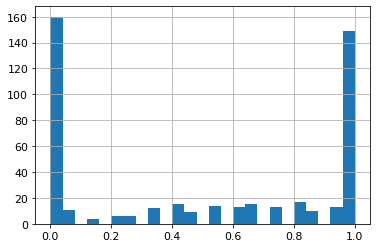

In [87]:
exp.dataset.df['touch_conf'].hist(bins=25)

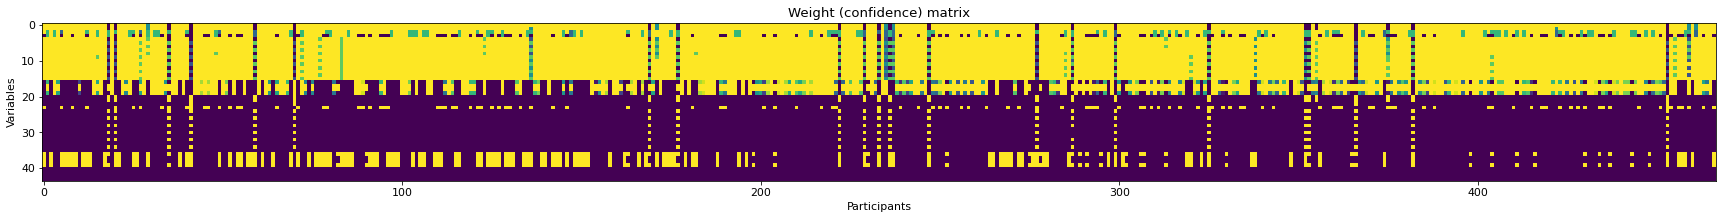

In [81]:
exp.dataset.df['S_postural_sway_conf'] = (~exp.dataset.df[['ST_postural_sway', 'BB_postural_sway', 'MML_postural_sway', 'FP_postural_sway']].isna()).sum(axis=1)/4
exp.dataset.df['NS_postural_sway_conf'] = (~exp.dataset.df[['DIGC_postural_sway', 'DIGRRL_postural_sway', 'FB_postural_sway', 'MP_postural_sway']].isna()).sum(axis=1)/4
exp.dataset.df['S_postural_sway_derivative_conf'] = (~exp.dataset.df[['ST_postural_sway_derivative', 'BB_postural_sway_derivative', 'MML_postural_sway_derivative', 'FP_postural_sway_derivative']].isna()).sum(axis=1)/4
exp.dataset.df['NS_postural_sway_derivative_conf'] = (~exp.dataset.df[['DIGC_postural_sway_derivative', 'DIGRRL_postural_sway_derivative', 'FB_postural_sway_derivative', 'MP_postural_sway_derivative']].isna()).sum(axis=1)/4
exp.dataset.df['gaze_silhouette_score_conf'] = (~exp.dataset.df[['BB_gaze_silhouette_score','S_gaze_silhouette_score']].isna()).sum(axis=1)/2
exp.dataset.df['mean_gaze_percent_right_conf'] = (~exp.dataset.df[['S_gaze_percent_right','BB_gaze_percent_right']].isna()).sum(axis=1)/2

exp.dataset.df['S_facing_forward_conf'] = (~exp.dataset.df[['ST_facing_forward', 'BB_facing_forward', 'MML_facing_forward', 'FP_facing_forward']].isna()).sum(axis=1)/4
exp.dataset.df['NS_facing_forward_conf'] = (~exp.dataset.df[['DIGC_facing_forward', 'DIGRRL_facing_forward', 'FB_facing_forward', 'MP_facing_forward']].isna()).sum(axis=1)/4

exp.dataset.df['S_eyebrows_complexity_conf'] = (~exp.dataset.df[['ST_eyebrows_complexity', 'BB_eyebrows_complexity', 'MML_eyebrows_complexity', 'FP_eyebrows_complexity']].isna()).sum(axis=1)/4
exp.dataset.df['NS_eyebrows_complexity_conf'] = (~exp.dataset.df[['DIGC_eyebrows_complexity', 'DIGRRL_eyebrows_complexity', 'FB_eyebrows_complexity', 'MP_eyebrows_complexity']].isna()).sum(axis=1)/4

exp.dataset.df['S_mouth_complexity_conf'] = (~exp.dataset.df[['ST_mouth_complexity', 'BB_mouth_complexity', 'MML_mouth_complexity', 'FP_mouth_complexity']].isna()).sum(axis=1)/4
exp.dataset.df['NS_mouth_complexity_conf'] = (~exp.dataset.df[['DIGC_mouth_complexity', 'DIGRRL_mouth_complexity', 'FB_mouth_complexity', 'MP_mouth_complexity']].isna()).sum(axis=1)/4

exp.dataset.df['S_postural_sway_complexity_conf'] = (~exp.dataset.df[['ST_head_movement_complexity', 'BB_head_movement_complexity', 'MML_head_movement_complexity', 'FP_head_movement_complexity']].isna()).sum(axis=1)/4
exp.dataset.df['NS_postural_sway_complexity_conf'] = (~exp.dataset.df[['DIGC_head_movement_complexity', 'DIGRRL_head_movement_complexity', 'FB_head_movement_complexity', 'MP_head_movement_complexity']].isna()).sum(axis=1)/4


exp.dataset.df['RTN_conf'] = exp.dataset.df['valid_name_calls'].apply(lambda x: np.sum(x))/3
exp.dataset.df['touch_conf'] = exp.dataset.df['number_of_touches'].apply(lambda x: 0 if np.isnan(x) else x/15  if x <=15 else 1. if x>= 16 else 0)


for conf_col in ['S_postural_sway_conf', 'NS_postural_sway_conf', 'S_postural_sway_derivative_conf', 'NS_postural_sway_derivative_conf',
                 'gaze_silhouette_score_conf', 'mean_gaze_percent_right_conf', 'proportion_of_name_call_responses_conf', 'average_response_to_name_delay_conf', 'touch_conf']:
    
    pass#exp.dataset.df.loc[exp.dataset.df[conf_col]==0, conf_col] = 1
    

conf_values = np.zeros((exp.dataset.num_samples, len(DEFAULT_PREDICTORS)))

for i, feat in enumerate(DEFAULT_PREDICTORS):
    
    if feat in TOUCH_VARIABLES:
        
        # These features don't depend on the number of touches, it is a value that we measures and so its confidence should be 1. 
        # We weight only the features that depend on the number of features.
        if feat in ['number_of_touches', 'number_of_target']:
            
            conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int)
        
        else:
            
            conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int) * exp.dataset.df['touch_conf']
        
    elif feat == 'proportion_of_name_call_responses':
        
        conf_values[:, i] = exp.dataset.df['RTN_conf']
        
    elif feat == 'average_response_to_name_delay':
        
        # 0 if the delay is missing, the proportion of valid  name calls otherwise
        
        conf_values[:, i] = (~np.isnan(exp.dataset._X_train[:,i])).astype(int) * exp.dataset.df['RTN_conf']
            
    else:
        conf_values[:, i] = exp.dataset.df['{}_conf'.format(feat)]
        
    
    
# ----------------- Shanity check: show the values that are missing but don't have a confidence set to 0 (should not be the case) -----------------------
# Pour toutes les nan des features
for coord in np.argwhere((mask_shap_present.astype(int)==0).astype(int) == 1):
    
    # Est-ce que la matrice de W est bien 0 ? 
    if conf_values[coord[0]][coord[1]] != 0 :
        print(coord, conf_values[coord[0]][coord[1]], exp.dataset._X_train[coord[0]][coord[1]])
        
        
# ----------------- Shanity check: show the values that have a confidence of 0 but are not msising (should only be the case for the RTN delay if no valid NC) -----------------------
# Pour toutes les nan des features
for coord in np.argwhere(conf_values==0):
    
    # Est-ce que la matrice de W est bien 0 ? 
    if not np.isnan(exp.dataset._X_train[coord[0]][coord[1]]):
        if exp.features_name[coord[1]] != 'average_response_to_name_delay':
            print(coord, exp.dataset._X_train[coord[0]][coord[1]], exp.features_name[coord[1]])
            
            
            
# --------------- Add the weights asssociated with the missingness ---------------------- #
conf_values = np.concatenate([conf_values, np.isnan(exp.dataset._X_train).astype(int)], axis=1)

fi(30, 35)
plt.title("Weight (confidence) matrix")
plt.imshow(conf_values.transpose())
plt.xlabel("Participants")
plt.ylabel("Variables")   
None

In [108]:
# Experimental ...

#exp.dataset.df['Measures Confidence Uniform'] = exp.dataset.df[['S_postural_sway_conf', 'NS_postural_sway_conf', 'S_postural_sway_derivative_conf',
#                                                        'NS_postural_sway_derivative_conf', 'gaze_silhouette_score_conf', 'mean_gaze_percent_right_conf', 
 #                                                       'RTN_conf', 'touch_conf']].sum(axis=1)/8


#exp.dataset.df['Measures Confidence Weighted'] =  conf_values[:, :12].sum(axis=1)/12

# Computation of a quality score for each of the participants


Now that we computed the relative contribution of each features (and their missingness) for each participants, $G(X)$, and a confidence score associated in each of the variables, $W(X)$, we can compute a general confidence score on the prediction based on the initial information we had on each sample. 

The way to think about it seems to be: okay we had a certain distribution of confidence across the variables, they all have different importance to make the final prediction, what is the final confidence we have for a sample ? 


$$ Quality (X^i) = \sum_{k=0}^K G(X^i_k) W(X^i_k) $$




This quality has value between 0 and 1, with 1 when all features are available.general_shap_values_normalized

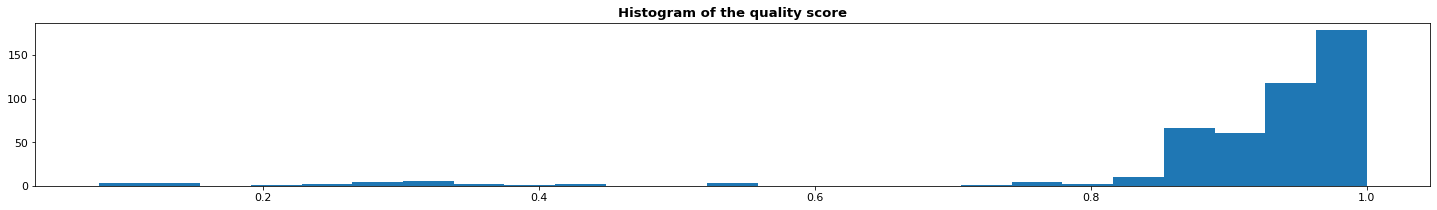

In [82]:
weighted_confidence_score = np.multiply(conf_values[:,:len(exp.features_name[:20])], shap_attributions_present).sum(axis=1)
np.save(os.path.join(DATA_DIR, 'weight_multimodal.npy'), weighted_confidence_score)

#weighted_confidence_score = np.multiply(conf_values, general_shap_values_normalized).sum(axis=1)
fi(25, 3)
plt.title("Histogram of the quality score", weight='bold')
plt.hist(weighted_confidence_score.flatten(), bins=25)
None

In [83]:
exp.predictions_df['conf'] = weighted_confidence_score

(0.0, 1.0)

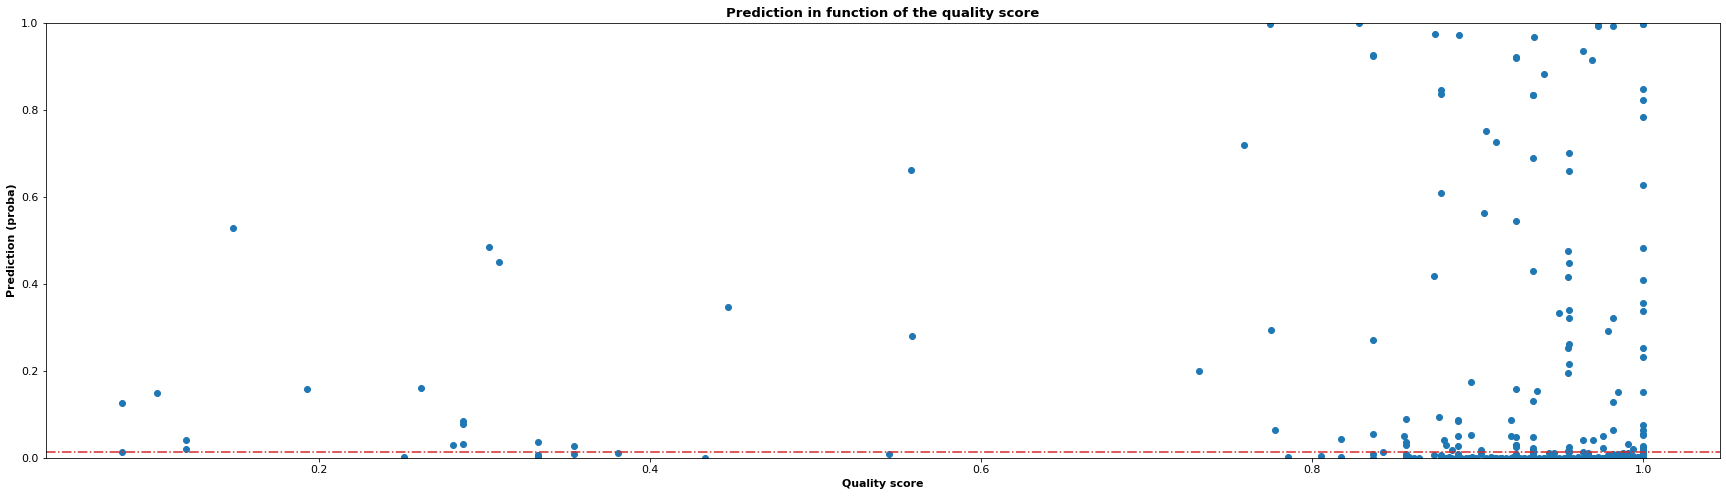

In [84]:
names = ['TP', 'TN', 'FP', 'FN']
#names = ['FP', 'FN']
fi(30, 8);ax=plt.gca()
plt.scatter(exp.predictions_df['conf'].to_numpy(), exp.predictions_df['y_pred'].to_numpy())
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.')
plt.title("Prediction in function of the quality score", weight='bold')
plt.xlabel("Quality score", weight='bold');plt.ylabel("Prediction (proba)", weight='bold')

plt.ylim([0, 1])

(0.0, 1.0)

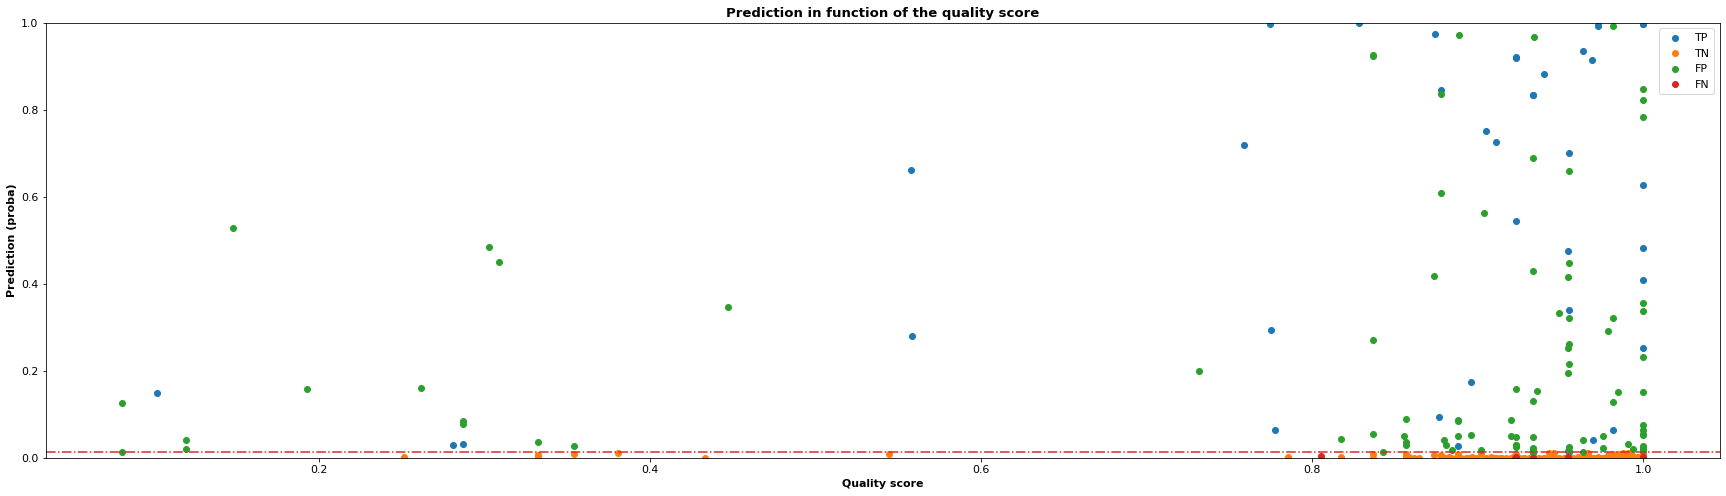

In [85]:
names = ['TP', 'TN', 'FP', 'FN']
#names = ['FP', 'FN']

fi(30, 8);ax=plt.gca()
for name in names:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['conf'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()
plt.title("Prediction in function of the quality score", weight='bold')
plt.xlabel("Quality score", weight='bold');plt.ylabel("Prediction (proba)", weight='bold')
plt.ylim([0, 1])
